In [32]:
from os import listdir
from os.path import isfile, join, basename
from pathlib import Path
from tabulate import tabulate


# Create a dictionary of data files
data_path  = 'data/'
data_lake  = { Path(f).stem : join(data_path,f) for f in listdir(data_path) if isfile(join(data_path,f)) }
data_table = [[str(i), k] for i, k in enumerate(data_lake)]
data_table = tabulate(data_table, headers=['id', 'Data Sets'])

header = "Available datasets in folder 'data'"
print(header)
print(len(header)*'=','\n')
print(data_table)

# data_set_id = input('Select a dataset (id):')
# data_set_loc = data_files[int(data_set_id)]

Available datasets in folder 'data'

  id  Data Sets
----  -----------
   0  djia


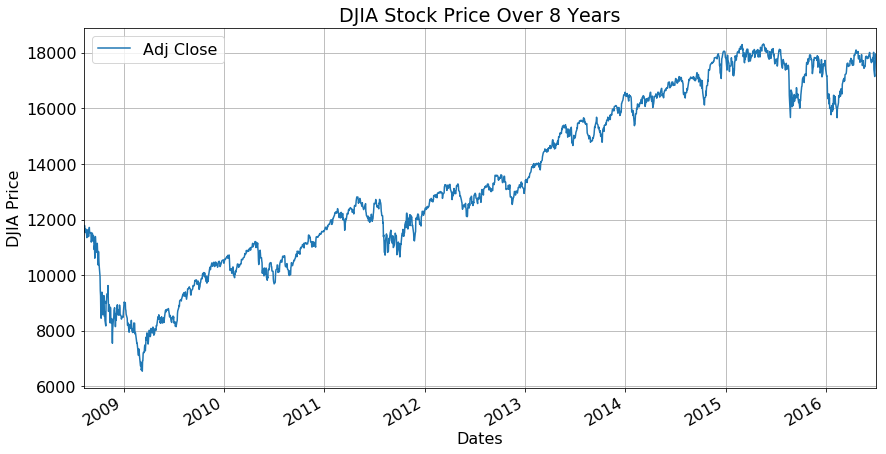

In [33]:
import re
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
%matplotlib inline

# Reads in data and checks to see none of the data is null
df = pd.read_csv(data_lake['djia'])
assert(df.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df = df.sort_values(by='Date')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Display code for moving averages
# ma_list = [10, 20, 50, 100, 200]
# boxes   = [widgets.Checkbox(value=False,description=str(i)+' Day MA', disabled=False) for i in ma_list]
# ma_dict = {str(ma_list[i]) : (boxes[i], None) for i in range(len(boxes))}

# def box_value_change(change):
#     window = re.search('\d*', change['owner'].description).group()
    
#     if change.new == True:
#         ma_dict[window] = ax.plot(
#             df['Adj Close'].rolling(window).mean(), label=window + 'Day MA')
#     else:
#         del boxes[window][1]
#     plt.show()

# for k, (box, _) in ma_dict.items():
#     box.observe(box_value_change, names='value')
#     display(box)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11,5))
ax = fig.add_axes([0,0,1,1])
df.plot(y='Adj Close',ax=ax)
# ax.plot(df['Adj Close'].rolling(100).mean(), label='10 Day MA')


ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

# boxes   = { str(ma_list[i]) : 
#            [,
#             None] for i in enumerate(ma_list) }
 
# print(boxes)
# for k, v in boxes.items():
    
#     # 
#     display(v[0])

In [34]:
# If high frequency signal is greater than lower frequency signal -> True
# With the equalitiy, we are also able to use it for modeling classical
# buy and hold strategy
buyIndicator  = lambda hf,lf: ~np.isnan(hf) and ~np.isnan(lf) and hf >= lf

def crossoverProfit(price, lf, hf=None, starting_cash=10000, indicator=lambda x,y: x > y, verbose=False):
    """
    Calculates the profit from crossover of the given low freq and high freq signals
    
    Inputs:
    hf        - higher frequency signal: price, 10 day mva etc.
    lf        - lower frequency signal: 50/200 day mva etc.
    indicator - function determining when hf is greater than lf
    
    Returns the profit made.
    """
    
    # Use the price if another average is not given
    if hf is None:
        hf = price
    
    assert lf.shape == hf.shape
    
    # Calculate crossover
    result     = np.array([indicator(hf[i], lf[i]) for i in range(len(lf))])
    result[1:] = np.not_equal(result[1:], result[0:-1])
    crossover  = result.astype(np.bool)
    
    # Extract time index of crossover
    crossover = np.array([time for time, signal in np.ndenumerate(crossover) if signal == True])
    
    cash = starting_cash
    for i, time in enumerate(crossover):
        if i % 2 == 0:
            num_stocks = cash / price[time]
        else:
            cash = num_stocks * price[time]
            
    # Make sure at end of time series to sell if currently holding stocks           
    if len(crossover) % 2 == 1:
        cash = num_stocks * price[-1]
        
    profit = cash - starting_cash
    
    if verbose:
        print(f'Initial value : $ {starting_cash:.2f}')
        print(f'Final value   : $ {cash.item():.2f}')
        print(f'Profit        : $ {profit.item():.2f}')
            
    return profit

In [35]:
def evaluateCrossoverStrategy(price, windows, indicator, starting_cash=10000):
    """
    Inputs:
    price        - as a single pandas data frame
    window_sizes - window lengths to use as moving averages
    indicator    - input passed to crossoverProfit (see documentation)
    
    Returns a matrix of the crossover profit generated with different moving average windows
    """
    
    profit_matrix = np.zeros((windows.size, windows.size))

    for i in range(windows.size):
        for j in range(windows.size):

            if (windows[i] == 1 and windows[j] == 1) or windows[j] > windows[i]:
                hf = price.rolling(windows[i]).mean().to_numpy()
                lf = price.rolling(windows[j]).mean().to_numpy()
                profit_matrix[i,j] = crossoverProfit(price=price.to_numpy(), 
                                                     lf=lf, hf=hf, 
                                                     starting_cash=starting_cash,
                                                     indicator=buyIndicator)
    
    return profit_matrix

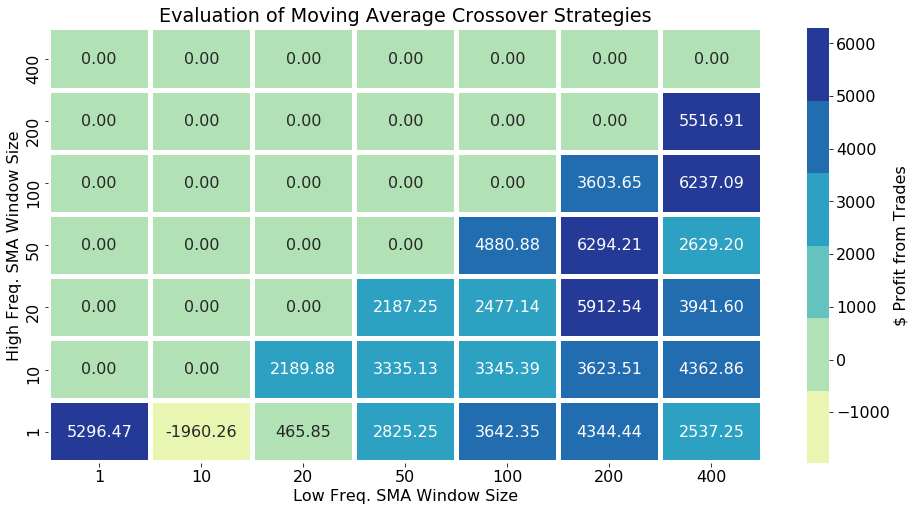

Best Crossover Pair: (50,200)
Buy and Hold Profit: $ 5296.47
Best Pair Profit   : $ 6294.21


In [36]:
# Visualize a heatmap of all the different crossover strategies
import seaborn as sns

window_sizes = np.array([1, 10, 20, 50, 100, 200, 400])



profit = evaluateCrossoverStrategy(
    df['Adj Close'], 
    windows=window_sizes, 
    indicator=buyIndicator,
    starting_cash=10000)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.rcParams['font.size'] = 16
ax = sns.heatmap(profit, annot=True, fmt='.2f', linewidth=4,
            xticklabels=window_sizes,
            yticklabels=window_sizes,
            cbar_kws={'label': '$ Profit from Trades'},
            cmap=sns.color_palette("YlGnBu"));
ax.invert_yaxis()
ax.set_xlabel('Low Freq. SMA Window Size')
ax.set_ylabel('High Freq. SMA Window Size')
ax.set_title('Evaluation of Moving Average Crossover Strategies')
plt.show()

best_pair  = np.unravel_index(profit.argmax(), profit.shape)
max_profit = profit[best_pair]

best_pair_str = f'({window_sizes[best_pair[0]]},{window_sizes[best_pair[1]]})'
print(f'Best Crossover Pair: {best_pair_str}')
print(f'Buy and Hold Profit: $ {profit[0,0]:.2f}')
print(f'Best Pair Profit   : $ {max_profit:.2f}')

The above plot shows the evaluation of various crossover strategies based on the simple moving average. This code can be used to select the best low frequency and high frequency moving average indicators for comparison with our model. The number in the (1,1) coordinate actually reflects the profit of a simple buy once and hold strategy (moving average window for both signals is simply the price itself). For the DJIA stock price, the best moving average pair to use is the 50 day MA as the short term indicator and the 200 day MA as the long term indicator.

## Caclulating Technical Indicators

In [104]:
indicators = {}
params = {}

def plotIndicator(val, title, x=None):
    plt.rcParams['font.size'] = 16
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    
    # If datetime information supplied
    if x is not None:
        plt.plot(x, val)
    else:
        plt.plot(val)
    ax.set_title(title)
    ax.set_xlabel('Dates')
    fig.autofmt_xdate(rotation=30)
    ax.grid()
    plt.show()

### 1. Simple Moving Average

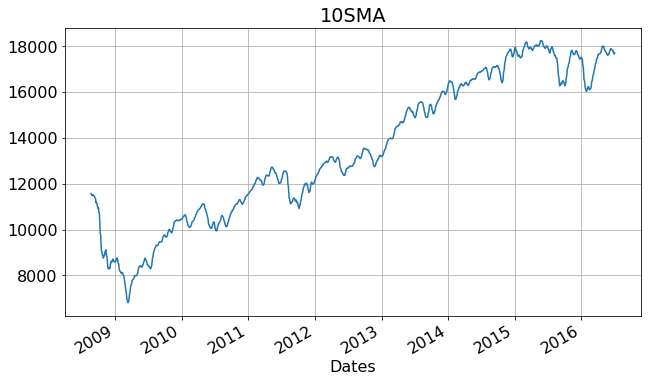

In [108]:
# As in paper calculate 10 day sample moving average
params['sma.window'] = 10

indicators[str(params['sma.window'])+'SMA'] = df['Adj Close'].rolling(params['sma.window']).mean().to_numpy()
plotIndicator(
    indicators[str(params['sma.window'])+'SMA'], 
    str(params['sma.window'])+'SMA', 
    x=df['Adj Close'].index)

### 2. Weighted Moving Average

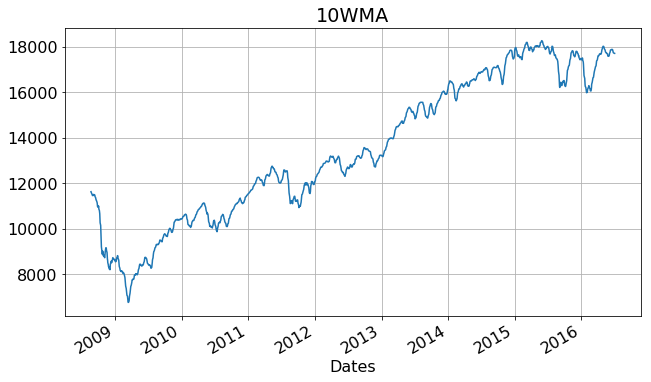

In [109]:
# As defined in paper calculate 10 day weighted moving average
params['wma.window'] = 10

w   = np.arange(1,params['wma.window']+1)[::-1] 
wma = lambda x: ((w*x) / w.sum()).sum()

indicators[str(params['wma.window'])+'WMA'] = df['Adj Close'].rolling(params['wma.window']).apply(wma, raw=True).to_numpy()
plotIndicator(
    indicators[str(params['wma.window'])+'WMA'], 
    str(params['wma.window'])+'WMA',
    x=df['Adj Close'].index)

### 3. Momentum

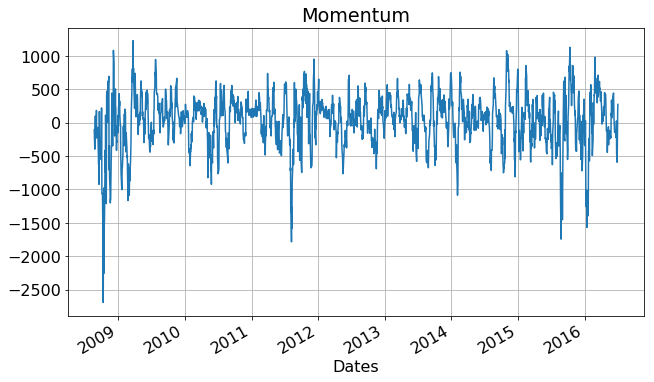

In [110]:
params['momentum.window'] = 10

momentum = np.full(df['Adj Close'].shape, np.nan)
ahead    = df['Adj Close'][params['momentum.window']:].to_numpy()
behind   = df['Adj Close'][:-params['momentum.window']].to_numpy()
momentum[params['momentum.window']:] =  ahead - behind
indicators['Momentum'] = momentum

plotIndicator(indicators['Momentum'], 'Momentum', x=df['Adj Close'].index)

### 4. Relative Strength Indicator

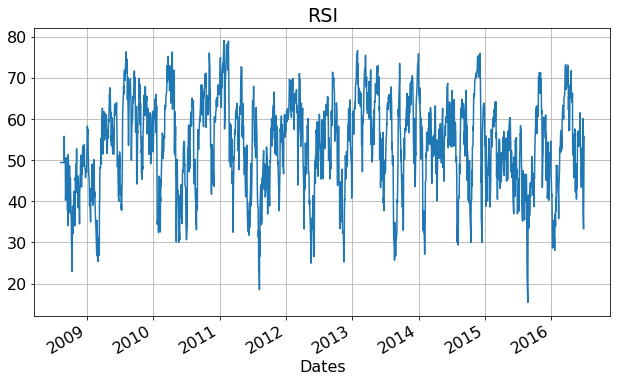

In [127]:
# Reference: https://github.com/mtamer/python-rsi/blob/master/Stock%20Screener/rsi.py
params['rsi.window'] = 14

def RSI(prices, n=14):
    deltas = np.diff(prices)
    seed   = deltas[:n]
    
    up   = seed[seed>=0].sum() / n
    down = -seed[seed<0].sum() / n
    rs   = up / down
    rsi  = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)
    
    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up     = (up*(n-1) + upval) / n
        down   = (down*(n-1) + downval) / n
        rs     = up / down
        rsi[i] = 100. - 100./(1.+rs)
        
    return rsi


        
indicators['RSI'] = RSI(df['Adj Close'].to_numpy())
plotIndicator(indicators['RSI'], 'RSI', x=df['Adj Close'].index)